# Load the Model

This script is used to load a pre-trained model from a specified local path. The steps included are:
1. Define a function to load the model using TensorFlow's `load_model` method.
2. Specify the path to the model file.
3. Load the model and confirm its successful loading.

Ensure that the model file exists at the specified path and that TensorFlow is properly installed in your environment.

In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from skimage.metrics import structural_similarity as ssim
import ipywidgets as widgets
import time
from scipy.io import wavfile

# Function to load the model from a local path
def load_model_from_path(model_path):
    return tf.keras.models.load_model(model_path)

# Load the model from a local path
model_path = 'E:/Mini Project/Dataset/Git/final_resnet_autoencoder_model.h5'
loaded_model = load_model_from_path(model_path)
print('Model loaded successfully.')

C:\Users\anand\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Model loaded successfully.


# Upload the Audio

This script handles the process of uploading an audio file, saving it, and preprocessing it for further evaluation. The steps included are:
1. Define an upload button for selecting and uploading an audio file.
2. Save the uploaded audio file to a specified path.
3. Display information about the uploaded file, including its name and size.
4. Play the uploaded audio for immediate feedback.
5. Preprocess the uploaded audio for further analysis.

Ensure the appropriate libraries are installed and imported for the successful execution of this script.

In [2]:
# Define the upload button
upload_button = widgets.FileUpload(accept='.wav', multiple=False)

# Define a function to process the uploaded file
def handle_upload(change):
    global custom_audio_file
    uploaded_file = list(upload_button.value.values())[0]
    
    # Save the uploaded file
    custom_audio_file = 'uploaded_audio.wav'
    with open(custom_audio_file, 'wb') as f:
        f.write(uploaded_file['content'])
    
    # Get file name and size
    file_name = uploaded_file['metadata']['name'] if 'metadata' in uploaded_file and 'name' in uploaded_file['metadata'] else 'Unknown'
    file_size = len(uploaded_file['content']) / 1024  # Size in KB

    print(f"File '{file_name}' uploaded successfully.")
    print(f"File Size: {file_size:.2f} KB")
    
    # Play the uploaded audio
    audio_data = preprocess_audio(custom_audio_file)
    display(Audio(audio_data, rate=16000))

# Attach the function to the upload button
upload_button.observe(handle_upload, names='value')

# Display the upload button
display(upload_button)

# Define a function to preprocess audio
def preprocess_audio(file_path, sample_rate=16000):
    audio, _ = librosa.load(file_path, sr=sample_rate)
    return audio

FileUpload(value={}, accept='.wav', description='Upload')

File 'NeighborSpeaking_10-[AudioTrimmer.com].wav' uploaded successfully.
File Size: 664.76 KB


# Evaluate the model

This script evaluates a trained autoencoder model on a given audio file and computes various metrics, including:
1. Mean Squared Error (MSE)
2. Signal-to-Noise Ratio (SNR)
3. Bitrate
4. Compression Ratio
5. Peak Signal-to-Noise Ratio (PSNR)
6. Structural Similarity Index (SSIM)
7. Compression and Decompression Time
8. Root Mean Square (RMS) of Original and Reconstructed Audio

The evaluation is performed on chunks of the audio file to handle long audio sequences.

Ensure that the model and audio file are correctly specified and accessible.


In [3]:
#Evaluate the autoencoder model on the given audio file and compute various metrics.
def evaluate_model_metrics(autoencoder, audio_file, sample_rate=16000):
    mse_list = []
    snr_list = []
    bitrate_list = []
    compression_ratio_list = []
    psnr_list = []
    ssim_list = []
    compression_time_list = []
    decompression_time_list = []
    rms_original_list = []
    rms_reconstructed_list = []

    # Load and preprocess the audio
    audio_data = preprocess_audio(audio_file, sample_rate)
    chunk_length = sample_rate
    num_chunks = int(np.ceil(len(audio_data) / chunk_length))
    audio_chunks = np.array_split(audio_data, num_chunks)

    reconstructed_chunks = []
    latent_representations = []

    # Process each chunk
    for i, chunk in enumerate(audio_chunks):
        if len(chunk) < chunk_length:
            chunk = np.pad(chunk, (0, chunk_length - len(chunk)), 'constant')

        chunk = np.expand_dims(chunk, axis=(0, -1))

        # Measure compression and decompression time
        start_time = time.time()
        reconstructed_chunk = autoencoder.predict(chunk)
        compression_time = time.time() - start_time
        compression_time_list.append(compression_time)

        start_time = time.time()
        _ = autoencoder.predict(chunk)
        decompression_time = time.time() - start_time
        decompression_time_list.append(decompression_time)

        reconstructed_chunks.append(reconstructed_chunk[0])

        # Get latent representation
        encoder_output = autoencoder.get_layer('encoder')(chunk)
        latent_representations.append(encoder_output.numpy())

        # Compute metrics
        mse = np.mean((chunk - reconstructed_chunk) ** 2)
        mse_list.append(mse)

        signal_power = np.mean(np.square(chunk))
        noise_power = np.mean(np.square(chunk - reconstructed_chunk))
        snr_value = 10 * np.log10(signal_power / noise_power)
        snr_list.append(snr_value)

        original_size_samples = np.prod(chunk.shape)
        reconstructed_size_samples = np.prod(reconstructed_chunk.shape)
        compressed_size = np.prod(encoder_output.shape)

        bytes_per_sample = 2
        original_size_bytes = original_size_samples * bytes_per_sample
        bitrate = (compressed_size * sample_rate * 16) / original_size_bytes if original_size_bytes > 0 else 0
        bitrate_list.append(bitrate)

        compression_ratio = (original_size_bytes / compressed_size) if compressed_size > 0 else 0
        compression_ratio_list.append(compression_ratio)

        psnr_value = 20 * np.log10(np.max(chunk) / np.sqrt(mse))
        psnr_list.append(psnr_value)

        # Normalize and compute SSIM
        original_chunk = np.squeeze(chunk)
        reconstructed_chunk = np.squeeze(reconstructed_chunk)
        original_chunk = (original_chunk - np.min(original_chunk)) / (np.max(original_chunk) - np.min(original_chunk))
        reconstructed_chunk = (reconstructed_chunk - np.min(reconstructed_chunk)) / (np.max(reconstructed_chunk) - np.min(reconstructed_chunk))
        ssim_value = ssim(original_chunk, reconstructed_chunk, data_range=1.0)
        ssim_list.append(ssim_value)

        # Compute RMS values
        rms_original = np.sqrt(np.mean(np.square(original_chunk)))
        rms_reconstructed = np.sqrt(np.mean(np.square(reconstructed_chunk)))
        rms_original_list.append(rms_original)
        rms_reconstructed_list.append(rms_reconstructed)

    # Compute average metrics
    avg_mse = np.mean(mse_list) if mse_list else float('nan')
    avg_snr = np.mean(snr_list) if snr_list else float('nan')
    avg_bitrate = np.mean(bitrate_list) if bitrate_list else float('nan')
    avg_compression_ratio = np.mean(compression_ratio_list) if compression_ratio_list else float('nan')
    avg_psnr = np.mean(psnr_list) if psnr_list else float('nan')
    avg_ssim = np.mean(ssim_list) if ssim_list else float('nan')
    avg_compression_time = np.mean(compression_time_list) if compression_time_list else float('nan')
    avg_decompression_time = np.mean(decompression_time_list) if decompression_time_list else float('nan')
    avg_rms_original = np.mean(rms_original_list) if rms_original_list else float('nan')
    avg_rms_reconstructed = np.mean(rms_reconstructed_list) if rms_reconstructed_list else float('nan')

    return {
        'mse_list': mse_list,
        'snr_list': snr_list,
        'bitrate_list': bitrate_list,
        'compression_ratio_list': compression_ratio_list,
        'psnr_list': psnr_list,
        'ssim_list': ssim_list,
        'compression_time_list': compression_time_list,
        'decompression_time_list': decompression_time_list,
        'rms_original_list': rms_original_list,
        'rms_reconstructed_list': rms_reconstructed_list,
        'reconstructed_audio': np.concatenate(reconstructed_chunks, axis=0),
        'avg_mse': avg_mse,
        'avg_snr': avg_snr,
        'avg_bitrate': avg_bitrate,
        'avg_compression_ratio': avg_compression_ratio,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_compression_time': avg_compression_time,
        'avg_decompression_time': avg_decompression_time,
        'avg_rms_original': avg_rms_original,
        'avg_rms_reconstructed': avg_rms_reconstructed
    }

# Evaluate the model on the custom audio
metrics = evaluate_model_metrics(loaded_model, custom_audio_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


C:\Users\anand\AppData\Local\Temp\ipykernel_9056\871275552.py:62: RuntimeWarning: overflow encountered in scalar multiply
  bitrate = (compressed_size * sample_rate * 16) / original_size_bytes if original_size_bytes > 0 else 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

#  Print Evaluation Metrics

This script calculates and prints average evaluation metrics for the autoencoder model.
Metrics include:
1. Mean Squared Error (MSE)
2. Signal-to-Noise Ratio (SNR)
3. Bitrate
4. Compression Ratio
5. Peak Signal-to-Noise Ratio (PSNR)
6. Structural Similarity Index (SSIM)
7. Compression and Decompression Time
8. Root Mean Square (RMS) of Original and Reconstructed Audio

The metrics are derived from the results of evaluating the model on a given audio file.

Ensure that the `metrics` dictionary is populated with the required values before running this script.

In [4]:
# Calculate averages from metrics
avg_mse = np.mean(metrics['mse_list']) if metrics['mse_list'] else float('nan')
avg_snr = np.mean(metrics['snr_list']) if metrics['snr_list'] else float('nan')
avg_bitrate = np.mean(metrics['bitrate_list']) if metrics['bitrate_list'] else float('nan')
avg_compression_ratio = np.mean(metrics['compression_ratio_list']) if metrics['compression_ratio_list'] else float('nan')
avg_psnr = np.mean(metrics['psnr_list']) if metrics['psnr_list'] else float('nan')
avg_ssim = np.mean(metrics['ssim_list']) if metrics['ssim_list'] else float('nan')
avg_compression_time = np.mean(metrics['compression_time_list']) if metrics['compression_time_list'] else float('nan')
avg_decompression_time = np.mean(metrics['decompression_time_list']) if metrics['decompression_time_list'] else float('nan')
avg_rms_original = np.mean(metrics['rms_original_list']) if metrics['rms_original_list'] else float('nan')
avg_rms_reconstructed = np.mean(metrics['rms_reconstructed_list']) if metrics['rms_reconstructed_list'] else float('nan')

# Print metrics with appropriate units and formatting
print(f"Average Mean Squared Error (MSE): {avg_mse:.10f}")
print(f"Average Signal-to-Noise Ratio (SNR): {avg_snr:.4f} dB")
print(f"\nAverage Bitrate: {avg_bitrate:.2f} bps")  # Bits per second
print(f"Average Compression Ratio: {avg_compression_ratio:.2f}")
print(f"\nAverage Peak Signal-to-Noise Ratio (PSNR): {avg_psnr:.2f} dB")
print(f"Average Structural Similarity Index (SSIM): {avg_ssim:.4f}")
print(f"\nAverage Compression Time: {avg_compression_time:.4f} s")
print(f"Average Decompression Time: {avg_decompression_time:.4f} s")
print(f"\nAverage RMS of Original Audio: {avg_rms_original:.4f}")
print(f"Average RMS of Reconstructed Audio: {avg_rms_reconstructed:.4f}")

Average Mean Squared Error (MSE): 0.0001895564
Average Signal-to-Noise Ratio (SNR): 18.5014 dB

Average Bitrate: -24870.91 bps
Average Compression Ratio: 0.50

Average Peak Signal-to-Noise Ratio (PSNR): 31.43 dB
Average Structural Similarity Index (SSIM): 0.9559

Average Compression Time: 0.1305 s
Average Decompression Time: 0.0953 s

Average RMS of Original Audio: 0.5530
Average RMS of Reconstructed Audio: 0.5477


# Plot Evaluation Metrics

This function plots various evaluation metrics for the autoencoder model based on the provided metrics.
The metrics plotted include:
1. Mean Squared Error (MSE)
2. Signal-to-Noise Ratio (SNR)
3. Peak Signal-to-Noise Ratio (PSNR)
4. Structural Similarity Index (SSIM)
5. Root Mean Square (RMS) of Original and Reconstructed Audio

The function also computes and displays the average value for each metric.

Ensure that the `metrics` dictionary is populated with the required values before calling this function.

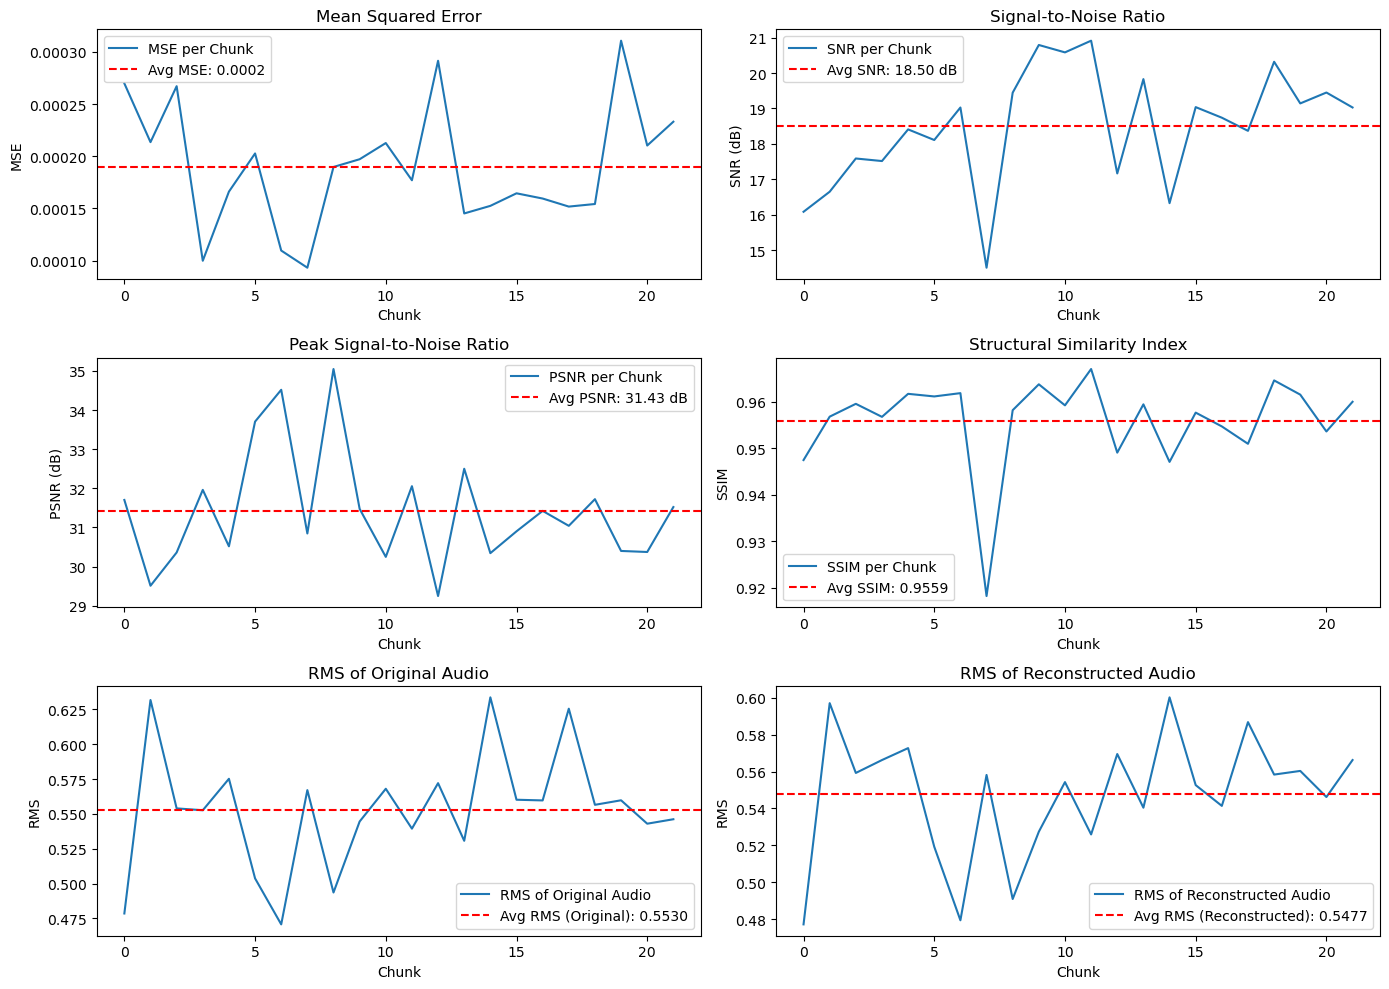

In [5]:
def plot_metrics(metrics):
    # Extract metrics from the provided dictionary
    mse_list = metrics['mse_list']
    snr_list = metrics['snr_list']
    bitrate_list = metrics['bitrate_list']
    compression_ratio_list = metrics['compression_ratio_list']
    psnr_list = metrics['psnr_list']
    ssim_list = metrics['ssim_list']
    compression_time_list = metrics['compression_time_list']
    decompression_time_list = metrics['decompression_time_list']
    rms_original_list = metrics['rms_original_list']
    rms_reconstructed_list = metrics['rms_reconstructed_list']

    # Compute averages for each metric
    avg_mse = np.mean(mse_list) if mse_list else float('nan')
    avg_snr = np.mean(snr_list) if snr_list else float('nan')
    avg_bitrate = np.mean(bitrate_list) if bitrate_list else float('nan')
    avg_compression_ratio = np.mean(compression_ratio_list) if compression_ratio_list else float('nan')
    avg_psnr = np.mean(psnr_list) if psnr_list else float('nan')
    avg_ssim = np.mean(ssim_list) if ssim_list else float('nan')
    avg_compression_time = np.mean(compression_time_list) if compression_time_list else float('nan')
    avg_decompression_time = np.mean(decompression_time_list) if decompression_time_list else float('nan')
    avg_rms_original = np.mean(rms_original_list) if rms_original_list else float('nan')
    avg_rms_reconstructed = np.mean(rms_reconstructed_list) if rms_reconstructed_list else float('nan')

    # Prepare the plots
    plt.figure(figsize=(14, 10))

    # Plot Mean Squared Error
    plt.subplot(3, 2, 1)
    plt.plot(mse_list, label='MSE per Chunk')
    plt.axhline(y=avg_mse, color='r', linestyle='--', label=f'Avg MSE: {avg_mse:.4f}')
    plt.title('Mean Squared Error')
    plt.xlabel('Chunk')
    plt.ylabel('MSE')
    plt.legend()

    # Plot Signal-to-Noise Ratio
    plt.subplot(3, 2, 2)
    plt.plot(snr_list, label='SNR per Chunk')
    plt.axhline(y=avg_snr, color='r', linestyle='--', label=f'Avg SNR: {avg_snr:.2f} dB')
    plt.title('Signal-to-Noise Ratio')
    plt.xlabel('Chunk')
    plt.ylabel('SNR (dB)')
    plt.legend()

    # Plot Peak Signal-to-Noise Ratio
    plt.subplot(3, 2, 3)
    plt.plot(psnr_list, label='PSNR per Chunk')
    plt.axhline(y=avg_psnr, color='r', linestyle='--', label=f'Avg PSNR: {avg_psnr:.2f} dB')
    plt.title('Peak Signal-to-Noise Ratio')
    plt.xlabel('Chunk')
    plt.ylabel('PSNR (dB)')
    plt.legend()

    # Plot Structural Similarity Index
    plt.subplot(3, 2, 4)
    plt.plot(ssim_list, label='SSIM per Chunk')
    plt.axhline(y=avg_ssim, color='r', linestyle='--', label=f'Avg SSIM: {avg_ssim:.4f}')
    plt.title('Structural Similarity Index')
    plt.xlabel('Chunk')
    plt.ylabel('SSIM')
    plt.legend()

    # Plot RMS of Original Audio
    plt.subplot(3, 2, 5)
    plt.plot(rms_original_list, label='RMS of Original Audio')
    plt.axhline(y=avg_rms_original, color='r', linestyle='--', label=f'Avg RMS (Original): {avg_rms_original:.4f}')
    plt.title('RMS of Original Audio')
    plt.xlabel('Chunk')
    plt.ylabel('RMS')
    plt.legend()

    # Plot RMS of Reconstructed Audio
    plt.subplot(3, 2, 6)
    plt.plot(rms_reconstructed_list, label='RMS of Reconstructed Audio')
    plt.axhline(y=avg_rms_reconstructed, color='r', linestyle='--', label=f'Avg RMS (Reconstructed): {avg_rms_reconstructed:.4f}')
    plt.title('RMS of Reconstructed Audio')
    plt.xlabel('Chunk')
    plt.ylabel('RMS')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_metrics(metrics)

# Evaluate Model with Custom Audio

This script provides functions to:
1. Play the original and reconstructed audio using IPython's Audio display.
2. Save audio data as WAV files.
3. Preprocess audio from a file.
4. Evaluate the model with custom audio, including metrics and visualization.

Ensure that the `autoencoder` model is properly loaded, and `custom_audio_file` is the path to the audio file to be processed before calling `evaluate_model_with_custom_audio`.

Functions:
- `play_audio`: Plays the original and reconstructed audio.
- `save_audio`: Saves audio data as a WAV file.
- `preprocess_audio`: Loads and preprocesses audio from a file.
- `evaluate_model_with_custom_audio`: Evaluates the autoencoder model with custom audio, including metrics calculation, visualization, and saving audio files.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


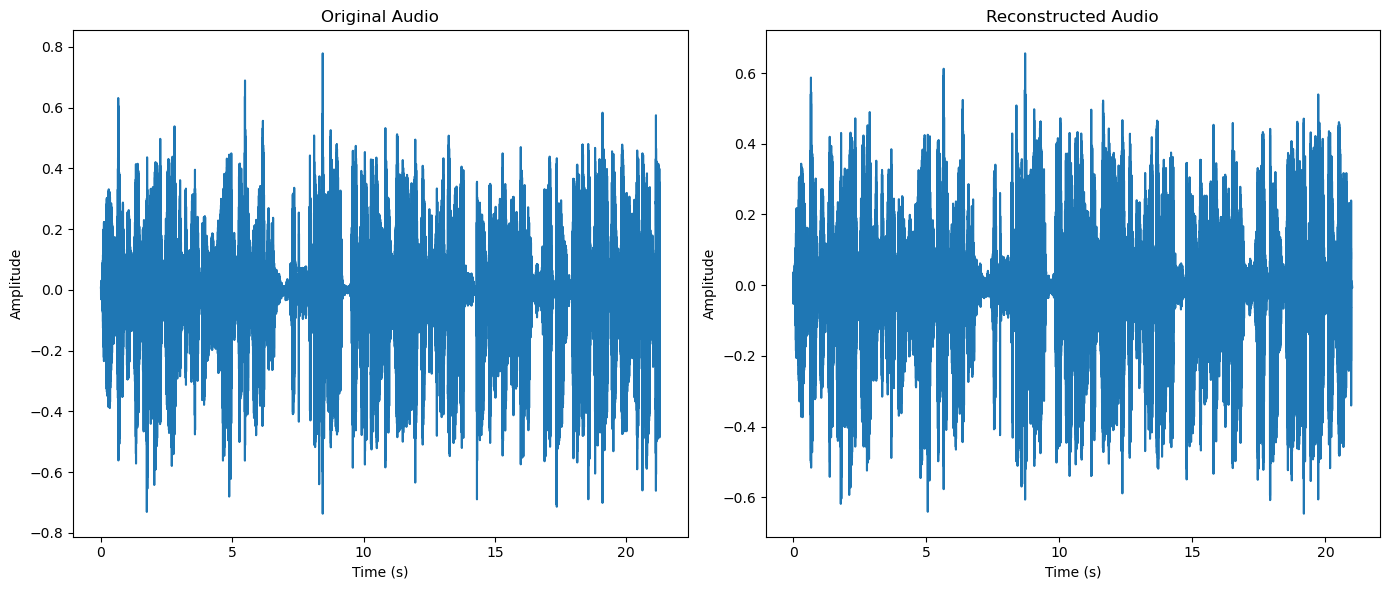

Original Audio Shape: (340320,)
Reconstructed Audio Shape: (336000,)
Playing original clean audio...


Playing reconstructed audio...


Audio files saved. Play them using an external audio player.
Original Audio Size: 664.76 KB
Reconstructed Audio Size: 656.29 KB
Original Audio Duration: 21.27 seconds
Reconstructed Audio Duration: 21.00 seconds
Original Audio RMS: 0.1216
Reconstructed Audio RMS: 0.1168


In [6]:
# Play the original and reconstructed audio.
def play_audio(original_audio, reconstructed_audio, sample_rate=16000):
    original_audio = np.squeeze(original_audio)
    reconstructed_audio = np.squeeze(reconstructed_audio)
    
    print("Original Audio Shape:", original_audio.shape)
    print("Reconstructed Audio Shape:", reconstructed_audio.shape)
    
    print("Playing original clean audio...")
    display(Audio(original_audio, rate=sample_rate))
    
    print("Playing reconstructed audio...")
    display(Audio(reconstructed_audio, rate=sample_rate))

# Save audio data as a WAV file.
def save_audio(filename, audio_data, sample_rate=16000):
    wavfile.write(filename, sample_rate, (audio_data * 32767).astype(np.int16))

# Load and preprocess audio from a file.
def preprocess_audio(file_path, sample_rate=16000):
    audio, _ = librosa.load(file_path, sr=sample_rate)
    return audio

# Evaluate the autoencoder model with custom audio and display results.
def evaluate_model_with_custom_audio(autoencoder, audio_file, sample_rate=16000):
    audio_data = preprocess_audio(audio_file, sample_rate)
    
    chunk_length = sample_rate  # 1 second
    num_chunks = int(np.ceil(len(audio_data) / chunk_length))
    audio_chunks = np.array_split(audio_data, num_chunks)

    reconstructed_chunks = []

    for chunk in audio_chunks[:-1]:  # Skip the last chunk
        if len(chunk) < chunk_length:
            chunk = np.pad(chunk, (0, chunk_length - len(chunk)), 'constant')
        
        chunk = np.expand_dims(chunk, axis=0)
        chunk = np.expand_dims(chunk, axis=-1)

        reconstructed_chunk = autoencoder.predict(chunk)
        reconstructed_chunks.append(reconstructed_chunk[0])

    reconstructed_audio = np.concatenate(reconstructed_chunks, axis=0)

    original_audio = audio_data
    
    original_duration = len(original_audio) / sample_rate  # Duration in seconds
    reconstructed_duration = len(reconstructed_audio) / sample_rate  # Duration in seconds
    
    original_rms = np.sqrt(np.mean(np.square(original_audio)))
    reconstructed_rms = np.sqrt(np.mean(np.square(reconstructed_audio)))

    plt.figure(figsize=(14, 6))
    
    time_axis = np.linspace(0, len(original_audio) / sample_rate, num=len(original_audio))

    plt.subplot(1, 2, 1)
    plt.plot(time_axis, original_audio)
    plt.title("Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    plt.subplot(1, 2, 2)
    plt.plot(time_axis[:len(reconstructed_audio)], reconstructed_audio)
    plt.title("Reconstructed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()
    
    play_audio(original_audio, reconstructed_audio, sample_rate)
    
    original_audio_filename = 'original_audio.wav'
    reconstructed_audio_filename = 'reconstructed_audio.wav'
    
    save_audio(original_audio_filename, original_audio, sample_rate)
    save_audio(reconstructed_audio_filename, reconstructed_audio, sample_rate)
    
    print("Audio files saved. Play them using an external audio player.")
    
    # Check the size of the original and reconstructed files directly from the filesystem
    original_file_size = os.path.getsize(audio_file) / 1024  # Size in KB
    reconstructed_file_size = os.path.getsize(reconstructed_audio_filename) / 1024  # Size in KB

    print(f"Original Audio Size: {original_file_size:.2f} KB")
    print(f"Reconstructed Audio Size: {reconstructed_file_size:.2f} KB")
    print(f"Original Audio Duration: {original_duration:.2f} seconds")
    print(f"Reconstructed Audio Duration: {reconstructed_duration:.2f} seconds")
    print(f"Original Audio RMS: {original_rms:.4f}")
    print(f"Reconstructed Audio RMS: {reconstructed_rms:.4f}")

# Evaluate the model with the uploaded audio
evaluate_model_with_custom_audio(loaded_model, custom_audio_file, sample_rate=16000)